In [5]:
from datetime import datetime, timedelta
from itertools import product
import json
# import h3
# import keplergl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [11]:
rides_df = pd.read_parquet('../data/raw/rides_data.parquet')
rides_df['Start Time'] = pd.to_datetime(rides_df['Start Time'])
rides_df['End Time'] = pd.to_datetime(rides_df['End Time'])

In [32]:
# with open('../data/raw/boundaries.json', 'r') as f:
#     communities_boundaries_json = f.read()
with open('../data/raw/boundaries.json', 'r') as f:
    features = json.load(f)["features"]

In [12]:
len(rides_df), rides_df['Start Time'].min(), rides_df['Start Time'].max()

(630816, Timestamp('2020-08-12 05:00:00'), Timestamp('2020-12-12 21:00:00'))

In [13]:
rides_df['Start Community Area Name'].value_counts().head(10)

LAKE VIEW          99318
LINCOLN PARK       80704
WEST TOWN          61413
NEAR WEST SIDE     32739
LOGAN SQUARE       29330
NEAR NORTH SIDE    28374
UPTOWN             27864
HYDE PARK          18863
EDGEWATER          14554
BELMONT CRAGIN     11041
Name: Start Community Area Name, dtype: int64

In [14]:
rides_df['Start Centroid Latitude'].nunique()

77

In [33]:
community_area_dict = {community['properties']['community']: community['properties']['shape_area'] for community in features}
community_len_dict = {community['properties']['community']: community['properties']['shape_len'] for community in features}
community_geometry_dict = {community['properties']['community']: community['geometry'] for community in features}

In [34]:
len(set(community_area_dict.keys()) & set(df['Start Community Area Name'].unique()))

77

In [31]:
rides_df['start_day'] = rides_df['Start Time'].dt.date
days = list(pd.date_range(rides_df['start_day'].min(), rides_df['start_day'].max(), freq='1D'))

In [72]:
full_df = pd.DataFrame(list(product(days, rides_df['Start Community Area Name'].unique())), 
                       columns=['start_day', 'community']).sort_values(['start_day', 'community'])

In [73]:
community_rides_stat = rides_df.groupby(
            [pd.Grouper(key="Start Time", freq="d"), "Start Community Area Name"]
        ).agg(rides_number=("Start Community Area Name", "count")).reset_index()
community_rides_stat['start_day'] = pd.to_datetime(community_rides_stat['Start Time'].dt.date)
community_rides_stat.columns = ['Start Time', 'community', 'rides_number', 'start_day']

In [74]:
full_df = full_df.merge(community_rides_stat, how='left', on=['start_day', 'community']).fillna(0)
full_df = full_df[['start_day', 'community', 'rides_number']]

In [75]:
full_df['start_day'].min(), full_df['start_day'].max()

(Timestamp('2020-08-12 00:00:00'), Timestamp('2020-12-12 00:00:00'))

In [82]:
full_df['day_of_year'] = full_df['start_day'].dt.dayofyear
full_df['day_of_week'] = full_df['start_day'].dt.day_of_week
full_df['is_weekend'] = full_df['day_of_week'].isin({5, 6}).astype(int)
full_df['week'] = full_df['start_day'].dt.isocalendar().week

In [83]:
full_df

start_day       community  rides_number  day_of_year  day_of_week  \
0    2020-08-12     ALBANY PARK          11.0          225            2   
1    2020-08-12  ARCHER HEIGHTS          12.0          225            2   
2    2020-08-12   ARMOUR SQUARE           8.0          225            2   
3    2020-08-12         ASHBURN           5.0          225            2   
4    2020-08-12  AUBURN GRESHAM          10.0          225            2   
...         ...             ...           ...          ...          ...   
9589 2020-12-12    WEST PULLMAN           1.0          347            5   
9590 2020-12-12      WEST RIDGE           0.0          347            5   
9591 2020-12-12       WEST TOWN          76.0          347            5   
9592 2020-12-12        WOODLAWN           0.0          347            5   
9593 2020-12-12               0           0.0          347            5   

      is_weekend  week  
0              0    33  
1              0    33  
2              0    33  
3              0    33  
4              0    33  
...          ...   ...  
9589           1    50  
9590           1    50  
9591           1    50  
9592           1    50  
9593           1    50  

[9594 rows x 7 columns]

In [20]:
communities_stat = df.groupby('Start Community Area Name', as_index=False).agg({'Trip ID': 'count'})
communities_stat['geometry'] = communities_stat['Start Community Area Name'].map(community_geometry_dict)

In [21]:
# with open('communities_stat_map_config.json', 'r') as f:
#     communities_stat_map_config = json.load(f)

# map_1 = keplergl.KeplerGl(config=communities_stat_map_config, height=800)
# # map_1.add_data(communities_boundaries_json)
# # map_1.add_data(community_geometry_dict['DOUGLAS'])
# map_1.add_data(communities_stat)
# map_1

# # with open('communities_stat_map_config.json', 'w') as f:
# #     json.dump(map_1.config, f)

In [22]:
df['Start Time'].value_counts()

08/29/2020 07:00:00 PM    1429
09/05/2020 06:00:00 PM    1380
09/07/2020 05:00:00 PM    1340
09/06/2020 06:00:00 PM    1330
09/07/2020 04:00:00 PM    1297
                          ... 
09/04/2020 11:00:00 PM       1
09/05/2020 04:00:00 AM       1
09/05/2020 10:00:00 PM       1
09/05/2020 11:00:00 PM       1
10/13/2020 03:00:00 AM       1
Name: Start Time, Length: 2274, dtype: int64

In [16]:
df['Trip Distance'] = pd.to_numeric(df['Trip Distance'].str.replace(',', '.'))
df['Trip Duration'] = pd.to_numeric(df['Trip Duration'].str.replace(',', '.'))
df = df.groupby(['start_day', 'Start Community Area Name'], as_index=False).agg({'Trip ID': 'count', 'Trip Distance': 'sum', 'Trip Duration': 'sum'})
df.columns = ['start_day', 'community', 'trips_num', 'trips_distance', 'trips_duration']

In [17]:
# hours = list(pd.date_range(df['start_hour'].min(), df['start_hour'].max(), freq='1H'))


In [19]:
df['start_day'] = pd.to_datetime(df['start_day'])

In [20]:
full_df = full_df.merge(df, how='left', on=['start_day', 'community']).fillna(0)

In [21]:
full_df[full_df['trips_num'] < 500]['trips_num'].hist(bins=30);

In [22]:
full_df['trips_num'] = full_df['trips_num'].astype(int)

In [23]:
full_df['trips_num'].describe()

count    9471.000000
mean       66.511878
std       159.331400
min         0.000000
25%         6.000000
50%        21.000000
75%        56.500000
max      1970.000000
Name: trips_num, dtype: float64

In [24]:
full_df.set_index('start_day')

community  trips_num  trips_distance  trips_duration
start_day                                                            
2020-08-12     ALBANY PARK         11         662.360        3792.475
2020-08-12  ARCHER HEIGHTS         12        1830.643        5012.921
2020-08-12   ARMOUR SQUARE          8         684.956        1248.554
2020-08-12         ASHBURN          5          42.557          12.285
2020-08-12  AUBURN GRESHAM         10         978.260         786.004
...                    ...        ...             ...             ...
2020-12-12       WEST LAWN          0           0.000           0.000
2020-12-12    WEST PULLMAN          1           2.103         605.000
2020-12-12      WEST RIDGE          0           0.000           0.000
2020-12-12       WEST TOWN         76       17002.785       24741.197
2020-12-12        WOODLAWN          0           0.000           0.000

[9471 rows x 4 columns]

In [33]:
full_df.set_index('start_day')[full_df.set_index('start_day')['community'] == 'BELMONT CRAGIN']['trips_num'].plot()

<AxesSubplot:xlabel='start_day'>

<AxesSubplot:xlabel='start_day'>

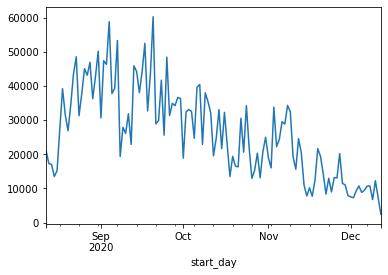

In [32]:
full_df.set_index('start_day')[full_df.set_index('start_day')['community'] == 'BELMONT CRAGIN']['trips_duration'].plot()

In [31]:
full_df[full_df['community'] == 'BELMONT CRAGIN']['trips_num'].hist(bins=20);

In [ ]:
# BELMONT CRAGIN
# LAKE VIEW

In [35]:
city_center = (41.881832, -87.623177)
# https://www.latlong.net/place/chicago-il-usa-1855.html

In [85]:
features = pd.read_parquet("../data/interim/interim_features.parquet")

In [86]:
features

start_day       community  rides_number  day_of_year  day_of_week  \
0    2020-08-12     ALBANY PARK          11.0          225            2   
1    2020-08-12  ARCHER HEIGHTS          12.0          225            2   
2    2020-08-12   ARMOUR SQUARE           8.0          225            2   
3    2020-08-12         ASHBURN           5.0          225            2   
4    2020-08-12  AUBURN GRESHAM          10.0          225            2   
...         ...             ...           ...          ...          ...   
9589 2020-12-12    WEST PULLMAN           1.0          347            5   
9590 2020-12-12      WEST RIDGE           0.0          347            5   
9591 2020-12-12       WEST TOWN          76.0          347            5   
9592 2020-12-12        WOODLAWN           0.0          347            5   
9593 2020-12-12            None           0.0          347            5   

      is_weekend  week  
0              0    33  
1              0    33  
2              0    33  
3              0    33  
4              0    33  
...          ...   ...  
9589           1    50  
9590           1    50  
9591           1    50  
9592           1    50  
9593           1    50  

[9594 rows x 7 columns]